# GDP


In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.regression.quantile_regression as smq

## Read Data

In [156]:
economist: pd.DataFrame = pd.read_hdf("data/democracy.h5", "economist")
freedom_house: pd.DataFrame = pd.read_hdf("data/democracy.h5", "freedomhouse")
v_dem: pd.DataFrame = pd.read_hdf("data/democracy.h5", "vdem")

## Create Democracy Score

<AxesSubplot:xlabel='year'>

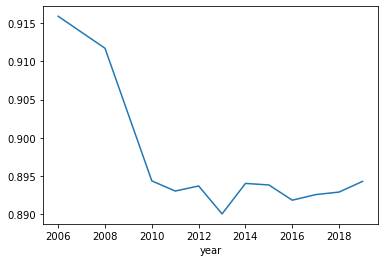

In [157]:
dem_raw = economist.add_prefix("econ-").join(freedom_house.add_prefix("free-"), how="outer").join(v_dem.add_prefix("v-dem-"), how="outer")
dem = dem_raw.copy().dropna()
dem["econ-score"] /= 10
dem["free-score"] = (7 - dem["free-score"])/6
dem["score"] = dem.mean(axis=1)
dem.to_hdf("data/democracy.h5", key="democracy")
dem_raw.to_hdf("data/democracy.h5", key="democracy_raw")
dem.loc["Netherlands"]["score"].plot()

## Get GDP data
Note: All data is in PPP (per capita) (as this is a much better measurement of wealth). Source: World Bank.

In [158]:
gdp: pd.DataFrame = pd.read_csv("data/gdp.csv", skiprows=[0, 1, 2, 3], index_col=[0])
gdp.drop(["Country Code", "Indicator Name", "Indicator Code", "Unnamed: 65"], axis=1, inplace=True)
gdp.columns = gdp.columns.astype(int)
gdp = gdp.unstack().reorder_levels([1, 0]).sort_index().to_frame("gdp_per_capita")
gdp.index.set_names(["country_name", "year"], inplace=True)
gdp = gdp.dropna()
gdp.loc["Netherlands"]

,gdp_per_capita
year,
1990,36461.419020
1991,37057.583128
1992,37405.929967
1993,37613.252194
1994,38494.217852
1995,39498.136822
1996,40691.890317
1997,42235.489069
1998,43933.568107


In [159]:
gdp_addition = pd.read_excel("data/penn-world-data.xlsx", "Data", index_col=[1, 3]).drop(["countrycode", "currency_unit"], axis=1)

In [160]:
add_gdp_pc = (0.85*gdp_addition["rgdpna"].loc[:]/gdp_addition["pop"].loc[:]).dropna()
additional = ~add_gdp_pc.index.isin(gdp.index)
gdp = pd.concat([gdp["gdp_per_capita"], add_gdp_pc[additional]]).to_frame("gdp_per_capita").dropna().sort_index()

## Get GDP Growth

In [161]:
gdp_growth = pd.read_csv("data/gdp_growth.csv", skiprows=[0, 1, 2, 3], index_col=[0])
gdp_growth.drop(["Country Code", "Indicator Name", "Indicator Code", "Unnamed: 65"], axis=1, inplace=True)
gdp_growth.columns = gdp_growth.columns.astype(int)
gdp_growth = gdp_growth.unstack().reorder_levels([1, 0]).sort_index().to_frame("gdp_growth")
gdp_growth.index.set_names(["country_name", "year"], inplace=True)
gdp_growth

gdp_growth
country_name year            
Afghanistan  1960         NaN
             1961         NaN
             1962         NaN
             1963         NaN
             1964         NaN
...                       ...
Zimbabwe     2016   -0.793105
             2017    3.192453
             2018    3.356166
             2019   -7.468627
             2020   -7.620388

[16226 rows x 1 columns]

## GDP to Democracy

Least Absolute Deviations because of the large outliers.

gdp_per_capita  econ-score  free-score  v-dem-score  \
country_name year                                                        
Afghanistan  2010     1957.029070       0.248    0.166667       0.2620   
             2011     1904.559926       0.248    0.166667       0.2620   
             2012     2075.491614       0.248    0.166667       0.2644   
             2013     2116.465258       0.248    0.166667       0.2620   
             2014     2102.384604       0.277    0.166667       0.2624   
...                           ...         ...         ...          ...   
Zimbabwe     2015     3707.622449       0.305    0.333333       0.2234   
             2016     3678.217095       0.305    0.333333       0.2186   
             2017     3795.642431       0.316    0.250000       0.2290   
             2018     3923.030495       0.316    0.333333       0.2276   
             2019     3630.033985       0.316    0.333333       0.2132   

                      score  
country_name year            
Afghanistan  2010  0.225556  
             2011  0.225556  
             2012  0.226356  
             2013  0.225556  
             2014  0.235356  
...                     ...  
Zimbabwe     2015  0.287244  
             2016  0.285644  
             2017  0.265000  
             2018  0.292311  
             2019  0.287511  

[1430 rows x 5 columns]

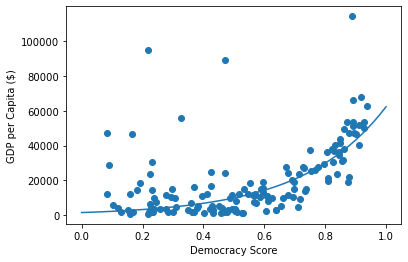

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:         gdp_per_capita   Pseudo R-squared:               0.2697
Model:                       QuantReg   Bandwidth:                      0.6328
Method:                 Least Squares   Sparsity:                        1.810
Date:                Sun, 30 Jan 2022   No. Observations:                  143
Time:                        16:32:09   Df Residuals:                      141
                                        Df Model:                            1
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.3798      0.183     40.298      0.000       7.018       7.742
score          3.6594      0.308     11.887      0.000       3.051       4.268
==============================================================================
"""

In [162]:
gdp_pc_dem = gdp.join(dem).dropna()
# gdp_growth_v_dem.groupby(gdp_growth_v_dem.index.get_level_values(0)).mean()
rel_gdp_dem: pd.DataFrame =  gdp_pc_dem.loc[(slice(None), [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]), :]
display(rel_gdp_dem)
rel_gdp_dem_avg = rel_gdp_dem.groupby(rel_gdp_dem.index.get_level_values(0)).mean()
# rel_gdp_dem_avg = rel_gdp_dem_avg[(rel_gdp_dem_avg["gdp_per_capita"] > 40000) & (rel_gdp_dem_avg["score"] < 0.5) == False]
plt.scatter(rel_gdp_dem_avg["score"], rel_gdp_dem_avg["gdp_per_capita"])
model = smq.QuantReg(np.log(rel_gdp_dem_avg["gdp_per_capita"]), sm.add_constant(rel_gdp_dem_avg[["score"]]))
res = model.fit(q=0.5)
x = np.linspace(0, 1)
plt.plot(x, np.exp(res.params[0] + res.params[1]*x))
plt.xlabel("Democracy Score")
plt.ylabel("GDP per Capita ($)")
plt.show()
res.summary()

## GDP Growth to Democracy
Note: Compensated to GDP

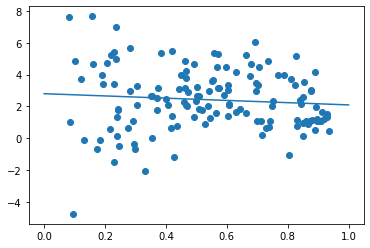

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             gdp_growth   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.078
Date:                Sun, 30 Jan 2022   Prob (F-statistic):              0.301
Time:                        16:32:10   Log-Likelihood:                -288.86
No. Observations:                 139   AIC:                             581.7
Df Residuals:                     137   BIC:                             587.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8003      0.404      6.929      0.000       2.001       3.599
score         -0.7041      0.678     -1.038      0.301      -2.045       0.637
==============================================================================
Omnibus:                        5.419   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.067   Jarque-Bera (JB):                6.576
Skew:                          -0.217   Prob(JB):                       0.0373
Kurtosis:                       3.973   Cond. No.                         5.38
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [163]:
gdp_growth_dem = gdp_growth.join(dem).join(gdp).dropna()
# gdp_growth_v_dem.groupby(gdp_growth_v_dem.index.get_level_values(0)).mean()
rel_gdp_growth_dem: pd.DataFrame =  gdp_growth_dem.loc[:, :]
rel_gdp_growth_dem_avg = rel_gdp_growth_dem.groupby(rel_gdp_growth_dem.index.get_level_values(0)).mean()
# rel_gdp_dem_avg = rel_gdp_dem_avg[(rel_gdp_dem_avg["gdp_per_capita"] > 40000) & (rel_gdp_dem_avg["score"] < 0.5) == False]
plt.scatter(rel_gdp_growth_dem_avg["score"], rel_gdp_growth_dem_avg["gdp_growth"])
model = sm.OLS(rel_gdp_growth_dem_avg["gdp_growth"], sm.add_constant(rel_gdp_growth_dem_avg[["score"]]))
res = model.fit(q=0.5)
x = np.linspace(0, 1)
plt.plot(x, res.params[0] + res.params[1]*x)
plt.show()
res.summary()

## Median GDP per Democracy Score

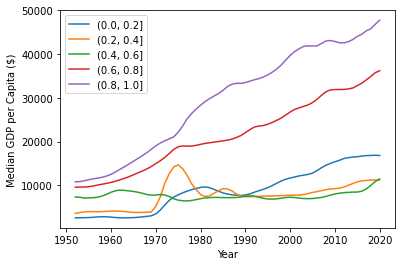

In [166]:
dem_gdp = dem_raw.join(gdp)
bins = pd.cut(dem_gdp["v-dem-score"], bins=[0, 0.2, 0.4, 0.6, 0.8, 1])
dem_gdp_data = dem_gdp.groupby([bins, "year"]).mean()["gdp_per_capita"].reorder_levels([1, 0]).sort_index().unstack().ewm(span=5).mean().rolling(3).mean()
dem_gdp_data.dropna(how="all", inplace=True)
plt.plot(dem_gdp_data)
plt.legend(dem_gdp_data.columns)
plt.xlabel("Year")
plt.ylabel("Median GDP per Capita ($)")
plt.show()